In [1]:
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from ldcast import forecast
from ldcast.visualization import plots
import eval_data

In [3]:
data_idx = 4
fn = f"calibrations/{data_idx}.pkl"
with open(fn, "rb") as f:
    y_hat = pickle.load(f)

In [4]:
batch_size = 1
resolution = 256
data_iter = eval_data.get_data_iter(
    "validset", resolution=resolution, batch_size=batch_size
)

/home/yppatel/csi/ldcast/ldcast/features/transform.py:80: RuntimeWarning: divide by zero encountered in log10
  log_scale = np.log10(scale).astype(np.float32)


Loading cached sampler from ../cache/sampler_nowcaster256_valid.pkl.
Loading cached sampler from ../cache/sampler_nowcaster256_test.pkl.
Loading cached sampler from ../cache/sampler_nowcaster256_train.pkl.


In [5]:
batches = [(batch_x, batch_y) for (batch_x, batch_y) in data_iter]

In [6]:
import osmnx as ox
G = ox.graph_from_place("Manhattan, New York City, New York", network_type="drive")

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [7]:
import networkx as nx
xs = list(nx.get_node_attributes(G, "x").values())
ys = list(nx.get_node_attributes(G, "y").values())

x_range = (np.min(xs), np.max(xs))
y_range = (np.min(ys), np.max(ys))

In [51]:
prediction = batches[0][0][0][0][0,0,0].cpu().numpy().copy()
threshold_mmh = 0.1
prediction[prediction < threshold_mmh] = 0

xy_to_forecast = lambda forecast, x, y : forecast[
    min(int(((y - y_range[0]) / (y_range[1] - y_range[0])) * prediction.shape[0]), prediction.shape[0] - 1),
    min(int(((x - x_range[0]) / (x_range[1] - x_range[0])) * prediction.shape[1]), prediction.shape[1] - 1)
]
node_predictions = [xy_to_forecast(prediction, x, y) for x, y in zip(xs, ys)]
rain_attributes = dict(zip(list(G), node_predictions))
nx.set_node_attributes(G, rain_attributes, name="rain")

In [52]:
# edge_rain_attributes = {e : G.edges[e]["travel_time"] * np.exp(np.mean([G.nodes[e[0]]["rain"], G.nodes[e[1]]["rain"]])) for e in G.edges}
edge_rain_attributes = {e : np.mean([G.nodes[e[0]]["rain"], G.nodes[e[1]]["rain"]]) for e in G.edges}
nx.set_edge_attributes(G, edge_rain_attributes, name="rain")

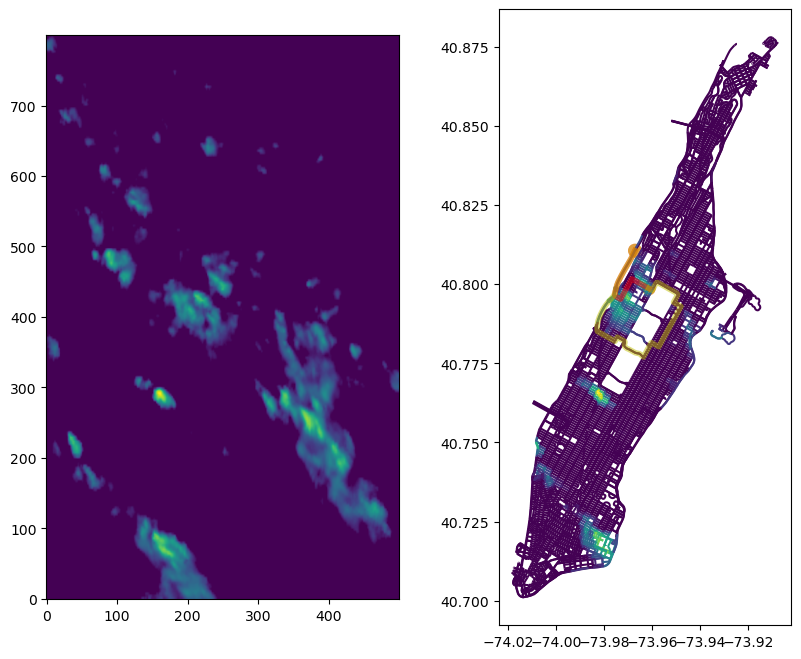

In [53]:
import cv2

orig = list(G)[1]
dest = list(G)[120]
route_time = ox.shortest_path(G, orig, dest, weight="travel_time")
route_rain = ox.shortest_path(G, orig, dest, weight="rain")

gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False)
prediction_resized = cv2.resize(prediction, (500, 800))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
axs[0].imshow(prediction_resized, origin="lower")
gdf_edges.plot(ax=axs[1], cmap="viridis", column="rain")
ox.plot_graph_routes(G, [route_time, route_rain], route_colors=["r", "y"], route_linewidth=1, node_size=2, ax=axs[1])
fig.set_tight_layout(True)